In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3
tf.config.list_physical_devices('GPU') 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


DATAPATH = os.path.abspath('../../data/')

1 Physical GPUs, 1 Logical GPUs


In [2]:
local_weights_path = os.path.join(DATAPATH, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_path)

In [3]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [4]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [5]:
# import zipfile

# local_zip = os.path.join(DATAPATH, 'cats_and_dogs_filtered.zip')
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall(DATAPATH)
# zip_ref.close()

In [6]:
base_dir = os.path.join(DATAPATH, 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 10,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 10 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 10,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 200,
            epochs = 20,
            validation_steps = 100,
            verbose = 2)

Epoch 1/20
200/200 - 30s - loss: 0.3511 - accuracy: 0.8720 - val_loss: 0.1406 - val_accuracy: 0.9550
Epoch 2/20
200/200 - 12s - loss: 0.2414 - accuracy: 0.9175 - val_loss: 0.1689 - val_accuracy: 0.9510
Epoch 3/20
200/200 - 12s - loss: 0.2311 - accuracy: 0.9190 - val_loss: 0.2189 - val_accuracy: 0.9510
Epoch 4/20
200/200 - 12s - loss: 0.2183 - accuracy: 0.9305 - val_loss: 0.1824 - val_accuracy: 0.9550
Epoch 5/20
200/200 - 13s - loss: 0.2337 - accuracy: 0.9290 - val_loss: 0.1820 - val_accuracy: 0.9620
Epoch 6/20
200/200 - 14s - loss: 0.2014 - accuracy: 0.9385 - val_loss: 0.1684 - val_accuracy: 0.9640
Epoch 7/20
200/200 - 13s - loss: 0.2342 - accuracy: 0.9340 - val_loss: 0.1425 - val_accuracy: 0.9690
Epoch 8/20
200/200 - 13s - loss: 0.2132 - accuracy: 0.9360 - val_loss: 0.1209 - val_accuracy: 0.9710
Epoch 9/20
200/200 - 13s - loss: 0.1886 - accuracy: 0.9455 - val_loss: 0.1246 - val_accuracy: 0.9670
Epoch 10/20
200/200 - 13s - loss: 0.1829 - accuracy: 0.9525 - val_loss: 0.1253 - val_accura

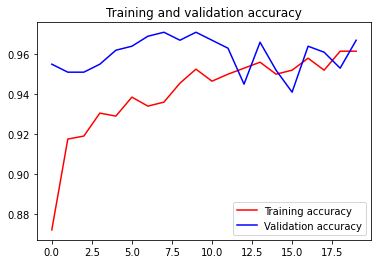

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()